# CBIS-DDSM (Digital Database for Screening Mammography) 图像分类项目
本文作者@ TOM GE [知乎主页](https://www.zhihu.com/people/tomge-88) 

### 1.数据集介绍图像/文本数据的统计分析

CBIS-DDSM（DDSM 的精选乳房成像子集）是 用于筛查乳房 X 光检查的数字数据库 (DDSM)的更新和标准化版本。DDSM 是一个包含 2,620 项扫描胶片乳腺摄影研究的数据库。它包含具有经过验证的病理信息的**正常、良性和恶性**病例。

### 2.项目背景/意义

中国正在进入老龄化社会，而我们的社会医疗资源严重缺乏，同时也出现医疗水平不平衡的情况。对于病人很多疾病如果发现的早，结果截然不同。如果有一种医疗辅助APP可以帮助人们
早期检测，例如每年的体检数据。通常人们都是自己评估自己的健康情况，而普通人没有相关医疗常识，所以很多“亲友团群”的偏方盛行：），我们可以通过医疗辅助APP，早期预警健康风险。

### 3.数据预处理
#### 3.1 数据介绍

In [1]:
# 解压数据集
!unzip -oq data/data128424/CBIS-DDSM.zip -d data/
print("done")

done


In [2]:
# 查看数据集的目录结构
! tree data/Mini_DDSM_Upload -d

data/Mini_DDSM_Upload
├── Benign
├── Cancer
└── Normal

3 directories


In [3]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [4]:
# 读取 Label 数据
benign_data_lable = pd.read_excel('data/Mini_DDSM_Upload/List_Benign.xlsx')
cancer_data_lable = pd.read_excel('data/Mini_DDSM_Upload/List_Cancer.xlsx')
normal_data_lable = pd.read_excel('data/Mini_DDSM_Upload/List_Normal.xlsx')

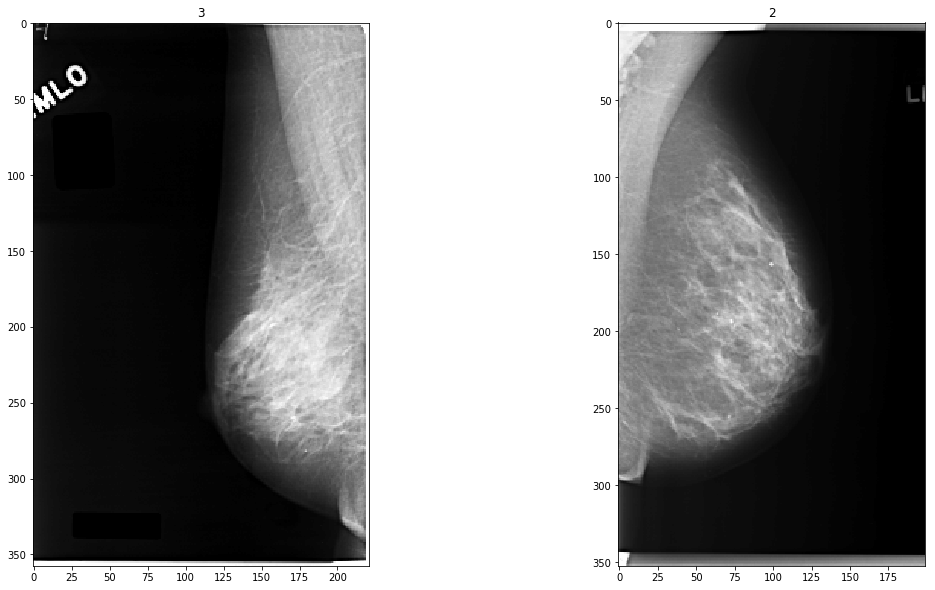

In [5]:
image_path_list = ['data/Mini_DDSM_Upload/Benign/1_C_0029_1.RIGHT_MLO.LJPEG.1_highpass.png','data/Mini_DDSM_Upload/Benign/10_C_0217_1.LEFT_MLO.LJPEG.1_highpass.png']
label_path_list = [benign_data_lable.loc[benign_data_lable.fileName == imagePath.split('/')[-1], 'Density'].iloc[0] for imagePath in image_path_list]

plt.figure(figsize=(16, 16))
plt.subplot(len(image_path_list), 2, 1)
plt.title(label_path_list[0])
plt.imshow(cv2.imread(image_path_list[0]))

plt.subplot(len(image_path_list), 2, 2)
plt.title(label_path_list[1])
plt.imshow(cv2.imread(image_path_list[1]))


plt.tight_layout()
plt.show()
   

In [6]:
# 检查原始图片大小
img_shape = cv2.imread(image_path_list[0]).shape
print('Original Image Shape {}'.format(img_shape))

# 检查数据集大小 
num_samples = len(benign_data_lable.index)
print('How many elements in benign_data_lable? {}'.format(num_samples))

# 检查标签类别
num_classes  = len([0,1,2]) # 正常、良性和恶性
print('How many classes in benign_data_lable? {}'.format(num_classes))

Original Image Shape (358, 221, 3)
How many elements in benign_data_lable? 3360
How many classes in benign_data_lable? 3


In [7]:
# 计算图像数据整体均值和方差
def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std


mean, std = get_mean_std(glob.glob('data/Mini_DDSM_Upload/Benign/*.png'))
print('mean:', mean)
print('std:', std)

Total images: 3360
mean: [0.28210744 0.28216255 0.28379513]
std: [0.30086238 0.30091951 0.30214825]


### 3.2 图像数据的统计分析

In [8]:
# 查看数据
benign_data_lable.head()

,View,fileName,Age,Density
0,RMLO,1_C_0029_1.RIGHT_MLO.LJPEG.1_highpass.png,66,3
1,LMLO,2_C_0029_1.LEFT_MLO.LJPEG.1_highpass.png,66,3
2,RCC,3_C_0029_1.RIGHT_CC.LJPEG.1_highpass.png,66,3
3,LCC,4_C_0029_1.LEFT_CC.LJPEG.1_highpass.png,66,3
4,RMLO,5_C_0033_1.RIGHT_MLO.LJPEG.1_highpass.png,60,3


In [9]:
# 参考数据集统计信息
benign_data_lable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   View      3360 non-null   object
 1   fileName  3360 non-null   object
 2   Age       3360 non-null   int64 
 3   Density   3360 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 105.1+ KB


In [10]:
# 检查 NaN 值
print('How many NaN value in benign_data_lable? {}'.format(benign_data_lable.isna().sum().sum()))

How many NaN value in benign_data_lable? 0


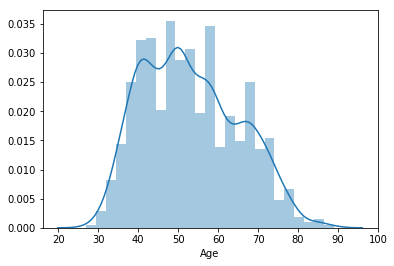

In [11]:
sns.distplot(a=benign_data_lable['Age'], kde=True)

In [12]:
benign_data_lable['Age'].describe()

count    3360.000000
mean       53.103571
std        12.025971
min        27.000000
25%        43.000000
50%        52.000000
75%        62.000000
max        89.000000
Name: Age, dtype: float64

In [13]:
#查看数据
cancer_data_lable.head()

,View,fileName,Age,Density
0,RMLO,1_C_0001_1.RIGHT_MLO.LJPEG.1_highpass.png,65,2
1,LMLO,2_C_0001_1.LEFT_MLO.LJPEG.1_highpass.png,65,2
2,RCC,3_C_0001_1.RIGHT_CC.LJPEG.1_highpass.png,65,2
3,LCC,4_C_0001_1.LEFT_CC.LJPEG.1_highpass.png,65,2
4,RMLO,5_C_0002_1.RIGHT_MLO.LJPEG.1_highpass.png,72,2


In [14]:
cancer_data_lable.count()

View        3596
fileName    3596
Age         3596
Density     3596
dtype: int64

In [15]:
# 检查是否NaN 值 
print('How many NaN value in benign_data_lable? {}'.format(benign_data_lable.isna().sum().sum()))

How many NaN value in benign_data_lable? 0


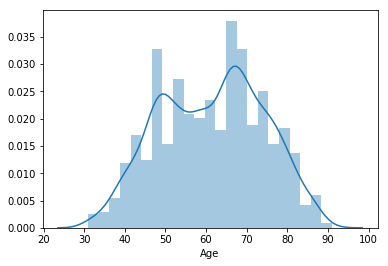

In [16]:
sns.distplot(a=cancer_data_lable['Age'], kde=True)

In [17]:
cancer_data_lable['Age'].describe()

count    3596.000000
mean       61.397108
std        12.796785
min        31.000000
25%        51.000000
50%        62.000000
75%        71.000000
max        91.000000
Name: Age, dtype: float64

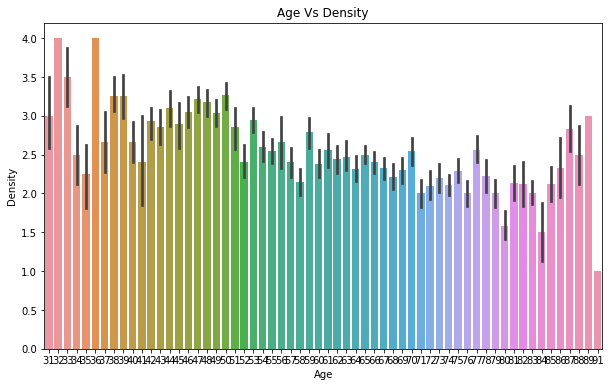

In [18]:
plt.figure(figsize=(10, 6))
plt.title('Age Vs Density')
sns.barplot(x=cancer_data_lable['Age'], y=cancer_data_lable['Density'])


 Normal : 2728 
 Benign : 3360 
 Cancer : 3596


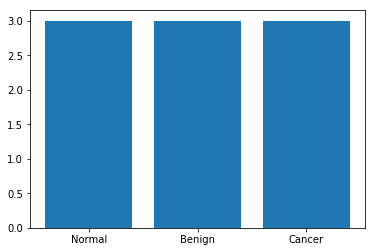

In [19]:
print(f" Normal : {normal_data_lable.shape[0]} \n Benign : {benign_data_lable.shape[0]} \n Cancer : {cancer_data_lable.shape[0]}")

class_names = ["Normal","Benign","Cancer"]
class_num = len(class_names)

plt.bar(x=class_names, height=class_num, width=0.8)
plt.show()

### 结论:
- 数据集无缺失值,Label值为int64 可进行数据分析,并且标签与数据对应关系明确.
- 从数据和图表中,我们可以看到病人的年龄是正态分布的,可对数据进行正则化
- 有一点我们需要注意,病人初期中位数为52岁,癌症患者62岁,在设计产品时需要提供老年人友好化界面,同时在43岁左右人群是产品主要推广的年龄用户群,以做到预防的好,发现的早.
- 数据分布不是非常平均,如果对模型准确率有影响,需要调整数据

### 3.3 数据集类的定义

In [20]:
import paddle
import paddle.vision.transforms as T

# 健康
normal_path =  'data/Mini_DDSM_Upload/Normal/'
x_normal = (normal_path + normal_data_lable['fileName'].astype(str)).tolist()
y_normal = [0]*len(x_normal)

# 良性
benign_path =  'data/Mini_DDSM_Upload/Benign/'
x_benign = (benign_path + benign_data_lable['fileName'].astype(str)).tolist()
y_benign = [1]*len(x_benign)

# 恶性
cancer_path =  'data/Mini_DDSM_Upload/Cancer/'
x_cancer = (cancer_path + cancer_data_lable['fileName'].astype(str)).tolist()
y_cancer = [2]*len(x_cancer)

x = np.asarray(x_normal + x_benign + x_cancer)
y = np.asarray(y_normal + y_benign + y_cancer)
data = np.stack([x, y], axis = 1)

data = np.stack([x, y], axis = 1)
np.random.shuffle(data)


num_classes = 3
num_samples = len(data)
BATCH_SIZE = 32
IMAGE_SIZE = img_shape

# 训练集 80%, 验证集 10%, 测试集 10%
train_data, val_data, test_data = np.split(data, [int(.8 * len(data)), int(.9 * len(data))])

print(f" train: {len(train_data)} shape: {train_data.shape}\n val:{len(val_data)} shape: {val_data.shape}\n test array : {len(test_data)}  shape : {test_data.shape}")


 train: 7747 shape: (7747, 2)
 val:968 shape: (968, 2)
 test array : 969  shape : (969, 2)


In [21]:
import os, glob

try:
    for f in glob.glob("*.txt"):
        os.remove(f)
   
except OSError:
    pass


!touch train_list.txt
!touch val_list.txt
!touch test_list.txt

In [22]:
train_list = open("train_list.txt", "w")
val_list = open("val_list.txt", "w")
test_list = open("test_list.txt", "w")

for x,  y in train_data:
    train_list.write(f"{x} {y}\n")

for x,  y in val_data:
    val_list.write(f"{x} {y}\n")

for x,  y in test_data:
    test_list.write(f"{x} {y}\n")

In [23]:
import paddlehub.vision.transforms as T
transforms = T.Compose([T.Resize((256, 256)), 
                        T.CenterCrop(224), 
                        T.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])], 
                        to_rgb=True)

In [24]:
class DDSM(paddle.io.Dataset):
    def __init__(self, transforms, mode = 'train'):
        self.mode = mode
        self.transforms = transforms
        self.num_classes = 3

        if self.mode == 'train':
            self.file = 'train_list.txt'

        elif self.mode == 'val':
            self.file = 'val_list.txt'

        else:
            self.file = 'test_list.txt'

        self.data = []   
        with open(self.file, 'r') as f:
            for line in f.readlines():
                line = line.strip()
                if line != '':
                    self.data.append(line)


    def __getitem__(self, idx):
        img_path, label = self.data[idx].split(' ')

        image = self.transforms(cv2.imread(img_path))
        image = image.astype('float32')

        return image, int(label)

    def __len__(self):
        return len(self.data)

### 3.4 数据集类的测试

In [25]:
train_dataset = DDSM( transforms, "train")
val_dataset = DDSM( transforms, "val")
test_dataset = DDSM( transforms, "test")

In [26]:
# 组建网络使用 dataloader
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

val_dataloader = paddle.io.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_dataloader = paddle.io.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)
    if step >= 5:
        break

0 [32, 3, 224, 224] [32]
1 [32, 3, 224, 224] [32]
2 [32, 3, 224, 224] [32]
3 [32, 3, 224, 224] [32]
4 [32, 3, 224, 224] [32]
5 [32, 3, 224, 224] [32]


### 4 训练模型
#### 4.1 Paddlehub model Fine-tune 训练
|数据集|相似度低|相似度高|
|---------|--------|--------|
|大|Fine-tune| **Fine-tuen or Retrain**|
|小| End of NN| Start of ConvNet|

**训练策略**

这里使用的是Resent50_vd_imagenet_ssld,数据集相似度低,训练数据集为 9684 ,所以我将采用 Fine-tuen or Retrain 并使用预训练模型参数初始化网络.

In [27]:
# 更新版本
!pip install --upgrade paddlepaddle -i https://mirror.baidu.com/pypi/simple
!pip install --upgrade paddlehub -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 108.4 MB 7.8 MB/s            
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 212 kB 8.5 MB/s            
     |████████████████████████████████| 84 kB 6.0 MB/s             
     |████████████████████████████████| 12.2 MB 13.7 MB/s            
  Attempting uninstall: paddlehub
    Found existing installation: paddlehub 2.0.4
    Uninstalling paddlehub-2.0.4:
      Successfully uninstalled paddlehub-2.0.4
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [28]:
import paddle
import paddlehub as hub
from paddlehub.finetune.trainer import Trainer

#加载预训练模型
model = hub.Module(name="resnet50_vd_imagenet_ssld", label_list=class_names)

Download https://bj.bcebos.com/paddlehub/paddlehub_dev/resnet50_vd_imagenet_ssld.tar.gz
[##################################################] 100.00%
Decompress /home/aistudio/.paddlehub/tmp/tmpma7otfx7/resnet50_vd_imagenet_ssld.tar.gz
[##################################################] 100.00%


[2022-02-22 16:41:32,909] [    INFO] - Successfully installed resnet50_vd_imagenet_ssld-1.1.0
W0222 16:41:32.992874   147 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0222 16:41:32.998138   147 device_context.cc:465] device: 0, cuDNN Version: 7.6.


load pretrained parameters success


In [29]:
#选择优化策略和运行配置
optimizer = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
trainer = Trainer(model, optimizer, use_gpu=True, checkpoint_dir='img_classification_ckpt')
trainer.train(train_dataset, epochs=100, batch_size=BATCH_SIZE, eval_dataset=val_dataset, log_interval=10, save_interval=1)

[2022-02-22 16:41:36,910] [ WARNING] - PaddleHub model checkpoint not found, start from scratch...
[2022-02-22 16:41:39,043] [   TRAIN] - Epoch=1/100, Step=10/241 loss=1.3683 acc=0.3531 lr=0.001000 step/sec=4.70 | ETA 01:25:32
[2022-02-22 16:41:41,044] [   TRAIN] - Epoch=1/100, Step=20/241 loss=1.0552 acc=0.3938 lr=0.001000 step/sec=5.00 | ETA 01:22:57
[2022-02-22 16:41:43,025] [   TRAIN] - Epoch=1/100, Step=30/241 loss=0.9940 acc=0.4156 lr=0.001000 step/sec=5.05 | ETA 01:21:50
[2022-02-22 16:41:45,028] [   TRAIN] - Epoch=1/100, Step=40/241 loss=0.9444 acc=0.4875 lr=0.001000 step/sec=4.99 | ETA 01:21:29
[2022-02-22 16:41:47,084] [   TRAIN] - Epoch=1/100, Step=50/241 loss=0.8994 acc=0.5000 lr=0.001000 step/sec=4.86 | ETA 01:21:42
[2022-02-22 16:41:49,158] [   TRAIN] - Epoch=1/100, Step=60/241 loss=0.9492 acc=0.4875 lr=0.001000 step/sec=4.82 | ETA 01:21:58
[2022-02-22 16:41:51,217] [   TRAIN] - Epoch=1/100, Step=70/241 loss=0.9094 acc=0.5094 lr=0.001000 step/sec=4.86 | ETA 01:22:04
[2022

### 5.评估模型

In [30]:
trainer.evaluate(test_dataset, BATCH_SIZE)


[2022-02-22 18:11:24,562] [    EVAL] - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation on validation dataset: | - Evaluation on validation dataset: / - Evaluation on validation dataset: - - Evaluation on validation dataset: \ - Evaluation 

{'loss': 2.2339701627494257,
 'metrics': defaultdict(int, {'acc': 0.674233825198638})}

### 6.模型预测

In [31]:
result = model.predict(['data/Mini_DDSM_Upload/Normal/1_A_0002_1.LEFT_MLO.LJPEG.1_highpass.png','data/Mini_DDSM_Upload/Benign/1_C_0029_1.RIGHT_MLO.LJPEG.1_highpass.png', 'data/Mini_DDSM_Upload/Cancer/1_C_0001_1.RIGHT_MLO.LJPEG.1_highpass.png'])
print(result)

[{'Normal': 1.0}, {'Benign': 0.9995479}, {'Cancer': 0.9999379}]
